# Imports:

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import copy


from pygsp import graphs, filters, reduction, plotting
from scipy import sparse, stats



%matplotlib inline

# Part IV
# Identify the players in each team

In [2]:
adjacency = pd.read_csv("./Data/Adjacencies/adjacency_hyperlinks.csv").values

In [3]:
adjacency_sparsed = sparse.csr_matrix(adjacency)

In [4]:
All_Nodes = pd.read_csv("./Data/All_Nodes.csv", sep='\t', encoding= 'utf-16')

In [5]:
G = graphs.Graph(adjacency_sparsed)
print("Number of nodes: ", str(G.N))

Number of nodes:  800


The nodes are divided into three categories: 736 players, 32 countries and 32 teams

## Heat Signal
Now lets start with identifying the players in each team. For this we start appling a heat signal on a player of a team, which then ideally transmits the heat to the different team members. In the example below we chose the player with the node 484, which represents "Thomas Müller", a german football player.

In [6]:
player_delta = 484                  #represents Thomas Müller (German football player)

In [7]:
def heat_signal(player_delta, G):
    DELTAS = [player_delta]
    s = np.zeros(G.N)
    s[DELTAS] = 1
    G.estimate_lmax()
    g = filters.Heat(G, tau=30)
    s = g.filter(s)
    
    return s, DELTAS

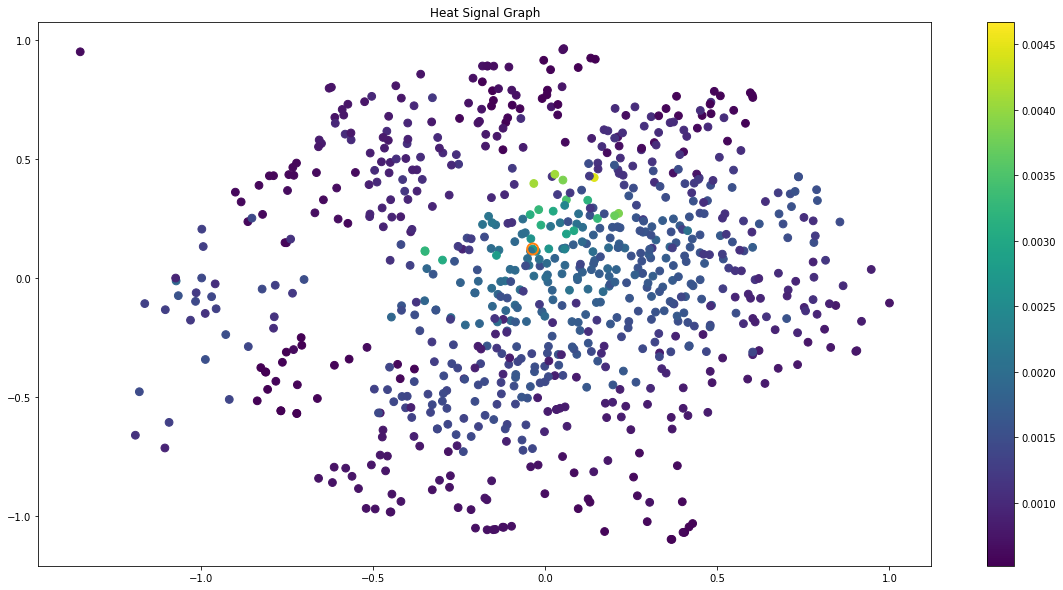

In [8]:
s, DELTAS = heat_signal(player_delta, G)
fig, ax = plt.subplots(figsize=(20, 10))
G.set_coordinates()
plotting.plot_signal(G, s, highlight=DELTAS ,backend= 'matplotlib',ax = ax, \
                     plot_name = 'Heat Signal Graph', vertex_size =60)

In the graph above we can see the heat signal on the network of hyperlinks where each player is connected to the page of the team. The heat signal is highlighted in with a orange circle. In order to have the best results the tau has to be relativly small (not larger than 60), because otherwise the heat will transmit to other players that have another correaltion between each other (like teammates in their clubs).  

In order to identify the players in each team we have set a upper limit that reduces the amount of results to a maximum of maxplayers, because each team has maximum number of 23 players (according to the FIFA rules for a world cup)! Within the "identify_players" method, we only take the players into account not the countries or national team nodes.

In [9]:
# Set upperbound for percentage
def set_upperbound(s, maxplayer):
    nan_counter = np.count_nonzero(np.isnan(s))
    s_sorted = np.sort(s)
    n = len(s_sorted)
    upperbound = s_sorted[n-maxplayer-nan_counter]
    
    return upperbound

In [10]:
# Identify players with with heat kernal
def identify_players(s, G):
    n = G.N 
    maxplayer = 23
    players_graphbased = []
    upperbound = set_upperbound(s, maxplayer)
    for i in range(n):
        if (s[i] > upperbound) & (i < 737):
            players_graphbased.append(i)
            
    print(players_graphbased)
    
    return players_graphbased

In [11]:
players_graphbased = identify_players(s, G)

[92, 104, 183, 251, 260, 265, 279, 302, 315, 364, 372, 484, 505, 528, 551, 570, 588, 589, 661, 674, 685, 718]


In [12]:
len(players_graphbased)

22

In [13]:
All_Nodes.iloc[player_delta, :]

Node        Thomas Müller
Category           player
Name: 484, dtype: object

Lets see the results of this graph analyse:

In [14]:
All_Nodes.iloc[players_graphbased, :]

,Node,Category
92,Jérôme Boateng,player
104,Julian Brandt,player
183,Julian Draxler,player
251,Matthias Ginter,player
260,Mario Gómez,player
265,Leon Goretzka,player
279,İlkay Gündoğan,player
302,Jonas Hector,player
315,Mats Hummels,player
364,Sami Khedira,player


That is a pretty good result. When comparing the result with the actual team players we got a accuary of 100 percent (when only choosing 23 players in total). However it is interesting to see that the countries are less connected between each other than the players themself. In the next step we will see that this method also works if we apply a delta signal on the countries.

In [15]:
country_delta = 737                      # represents Germany

In [16]:
s, DELTAS = heat_signal(country_delta, G)

In [17]:
players_graphbased = identify_players(s, G)

[92, 104, 183, 251, 260, 265, 279, 302, 315, 364, 372, 484, 505, 528, 551, 570, 588, 589, 661, 674, 685, 718]


Now lets see if the we predicted the player right, based on the graph.

In [18]:
heat_result = All_Nodes.iloc[players_graphbased, :]

In [19]:
player_truth = pd.read_csv("./Data/Team_Players.csv", sep='\t', encoding= 'utf-8')

def create_true_list(player_truth):
    true_list = []
    for i in range(player_truth.shape[0]):
            true_list.append(player_truth.values[i,0])
    return true_list        
  

In [20]:
true_list = create_true_list(player_truth)

In [21]:
def check_true_label(graph_array, true_list, old_result, extra):
    n = len(graph_array)
    counter = 0
    
    true_country = []

    for j in range(n):
        found = False
        for t in range(len(true_list)):
            if (old_result.values[j,0+extra] in true_list[t]) & (old_result.values[j,1+extra] == 'player'):
                player_info = true_list[t].split(',')
    
                true_country.append(player_info[0])
                counter += 1
                found = True
                
        if found == False:
            true_country.append("Not found or not a player")
            
            
    print("Players found: " + str(counter) + "/" + str(n) + " nodes")
    
    true_label = pd.DataFrame({'True label': true_country})
    final_result = old_result.assign(true_label=true_label.values)
    
    return final_result

In [22]:
heat_final_result = check_true_label(players_graphbased, true_list, heat_result, 0)

Players found: 22/22 nodes


In [23]:
heat_final_result

,Node,Category,true_label
92,Jérôme Boateng,player,Germany national football team
104,Julian Brandt,player,Germany national football team
183,Julian Draxler,player,Germany national football team
251,Matthias Ginter,player,Germany national football team
260,Mario Gómez,player,Germany national football team
265,Leon Goretzka,player,Germany national football team
279,İlkay Gündoğan,player,Germany national football team
302,Jonas Hector,player,Germany national football team
315,Mats Hummels,player,Germany national football team
364,Sami Khedira,player,Germany national football team


In [24]:
heat_final_result['true_label'].describe()

count                                 22
unique                                 1
top       Germany national football team
freq                                  22
Name: true_label, dtype: object

In [25]:
def create_PieChart_array(dataframe):
    chart_array = dataframe['true_label'].values
    n = len(chart_array)
    elements = []

    # indentify the number of elements
    for i in range(n):
        if chart_array[i] not in elements:
            elements.append(chart_array[i])

    # counts the number of elements in dataframe
    element_counter = np.zeros(len(elements))
    for i in range(len(elements)):
        for j in range(n):
            if chart_array[j] == elements[i]:
                element_counter[i] += 1
                
    return element_counter, elements

In [26]:
def create_PieChart(dataframe):
    pie_chart_array = create_PieChart_array(dataframe)
    patches, texts, _ = plt.pie(pie_chart_array[0], shadow=True, startangle=90, autopct='%1.1f%%')
    plt.legend(patches, pie_chart_array[1], loc="best")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

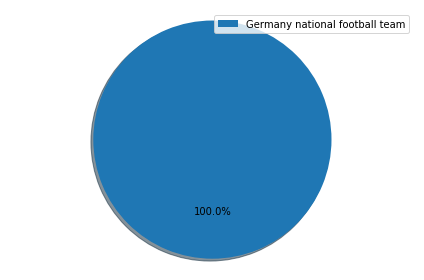

In [27]:
create_PieChart(heat_final_result)

As a result we can see that with applying the heat filter we can identify the teams pretty good. 

In [28]:
def built_clusting(G):
    team_predictions = []
    for i in range(736,768):
        t, _ = heat_signal(i, G)
        players_graphbased = identify_players(t, G)
        team_predictions.append(players_graphbased)
    
    return team_predictions

In [29]:
def assign_values(All_Nodes, team_predictions):
    nodes_local = All_Nodes.copy(deep=True)
    nodes_local['team_value'] = ''
    size = nodes_local.shape[0]
    for i in range(size):
        found = False
        for j in range(len(team_predictions)):
            for l in range(len(team_predictions[j])):
                if nodes_local.index.values[i] == team_predictions[j][l]:
                    nodes_local.iloc[i, 2] = j
                    found = True
        if found == False:
            nodes_local.iloc[i, 2] = 40
                    
        
    return nodes_local

In [30]:
team_predictions = built_clusting(G)
Nodes_prediction = assign_values(All_Nodes, team_predictions)

[93, 210, 237, 240, 253, 266, 272, 288, 289, 322, 394, 424, 430, 593, 620, 622, 629, 631, 641, 642, 687, 734]
[92, 104, 183, 251, 260, 265, 279, 302, 315, 364, 372, 484, 505, 528, 551, 570, 588, 589, 661, 674, 685, 718]
[20, 127, 128, 149, 152, 158, 194, 215, 227, 228, 230, 235, 247, 337, 436, 439, 468, 531, 569, 638, 667, 719]
[34, 87, 125, 131, 172, 223, 225, 233, 274, 275, 339, 418, 437, 440, 483, 530, 537, 558, 572, 632, 633, 634]
[4, 38, 45, 68, 89, 110, 118, 187, 220, 284, 310, 399, 416, 441, 451, 457, 498, 533, 541, 584, 606, 665]
[16, 71, 101, 121, 129, 133, 151, 161, 167, 169, 222, 301, 333, 378, 423, 454, 456, 458, 677, 706, 707, 720]
[72, 85, 88, 91, 138, 214, 254, 264, 269, 335, 385, 391, 393, 408, 411, 461, 534, 543, 548, 595, 673, 731]
[43, 168, 171, 221, 244, 307, 373, 405, 433, 444, 500, 502, 504, 510, 532, 563, 614, 628, 650, 675, 679, 691]
[12, 47, 50, 52, 60, 108, 124, 127, 302, 323, 326, 376, 474, 494, 513, 547, 568, 575, 616, 661, 676, 701]
[5, 41, 42, 111, 123, 12

In [31]:
signal_category = Nodes_prediction['team_value'].values

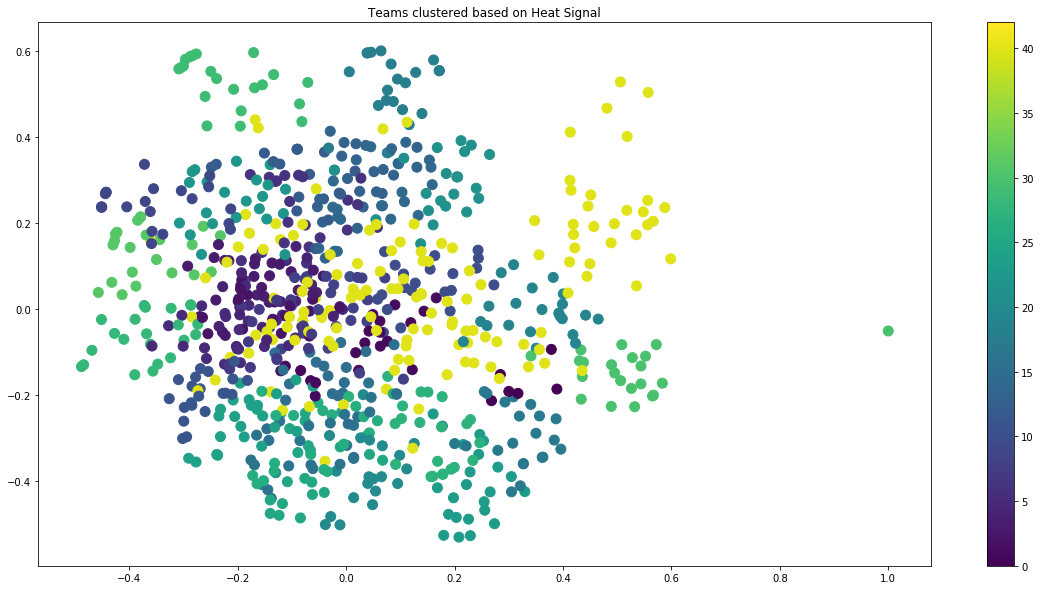

In [32]:
fig, ax = plt.subplots(figsize=(20, 10))
G.set_coordinates()
plotting.plot_signal(G, signal_category,backend= 'matplotlib',ax = ax, \
                    plot_name = 'Teams clustered based on Heat Signal', \
                     vertex_size =100)

The graph above shows the different teams, based on the clusting of the heat signal. The yellow nodes are nodes that either were not assiged to a team or are not part of the category "players".

## Pearson correlation
In this section we will compute the Pearson correlation score between the feature vector of each playerin order to identify the players in each team. The intention of this attempt is that high correlation is mostly due to similar behaviour exhibited by the team structure.

In [33]:
player = 484          #represents Thomas Müller

We will start by loading all the nodes with their number of visits per day (see README) normalised. For the following parts we will only take the columns into account that consists of the actual number of visits per day.

In [34]:
features_normalised = pd.read_csv("./Data/All_Nodes_During_WC_Normalised.csv", sep='\t', encoding= 'utf-16').values

In the next step we compute the pearson correlation between each player, given as input the feature vector.

In [35]:
def compute_pearson_correlation_array(feature_normalised):

    n = features_normalised.shape[0]-64
    pearson_array = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n): #symetric graph
            r_row, p_value = stats.pearsonr(features_normalised[i, 2:43], features_normalised[j, 2:43])
            pearson_array[j,i] = r_row
            pearson_array[i,j] = pearson_array[j,i]     
    
    return pearson_array
    

Now we have the pearson correlation between each player and we can start filtering the players. In order to do so, we have to set a certain threshold that limits the total number of nodes. To calculate the threshold we will use the same function as for the heat signal. The maximum number of players will be set again to 23 players.

In [36]:
def filter_players(player, threshold):

    counter = 0
    filtered_players = []
    n = 736
    for i in range(n):
        if (pearson_array[i,player] > threshold) & (i < 737):
            counter += 1
            filtered_players.append(i)
    
    return filtered_players          

In [37]:
pearson_array = compute_pearson_correlation_array(features_normalised)
pearson_array = np.nan_to_num(pearson_array)
pearson_array = np.absolute(pearson_array)

df_pearson_array = pd.DataFrame(pearson_array)
df_pearson_array.to_csv('./Data/Adjacencies/adjacency_pearson_correaltion.csv', index=False)

In [38]:
def run_pearson_correlation_for_node(node, features_normalised):
    
    number_of_nodes = 25     #23 players + national team + country

    
    upperlimit = set_upperbound(pearson_array[node], number_of_nodes+1)
    filtered_nodes = filter_players(node, upperlimit)
    
    pearson_result = All_Nodes.iloc[filtered_nodes, :] 
    pearson_final_result = check_true_label(filtered_nodes, true_list, pearson_result, 0)
    
    return pearson_final_result

In [39]:
pearson_final_result = run_pearson_correlation_for_node(player, features_normalised) 

Players found: 25/25 nodes


In [40]:
pearson_final_result

,Node,Category,true_label
40,Javier Aquino,player,Mexico national football team
92,Jérôme Boateng,player,Germany national football team
104,Julian Brandt,player,Germany national football team
146,José de Jesús Corona,player,Mexico national football team
183,Julian Draxler,player,Germany national football team
213,Marco Fabián,player,Mexico national football team
241,Jesús Gallardo,player,Mexico national football team
251,Matthias Ginter,player,Germany national football team
260,Mario Gómez,player,Germany national football team
271,Andrés Guardado,player,Mexico national football team


In [41]:
pearson_final_result['true_label'].describe()

count                                 25
unique                                 2
top       Germany national football team
freq                                  15
Name: true_label, dtype: object

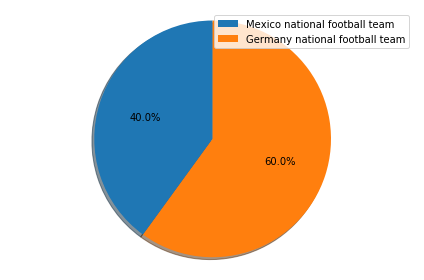

In [42]:
create_PieChart(pearson_final_result)

We can see that the pearson correlation acutally identify many players that are in the same team, but the overall accuary is not as good as with the heat signal. One reason could be that many teams had the match days on the same dates, which means in this case Mexico and Germany indeed played one match against each other, but the other days they both played against other teams, but on the same day. The other reason could be, that Mexico only last til the last 16, so they only had one match not on the same day as Germany. In order to give evidence to this assumption, we will repeat the same correlation for Croatia, which, unlike Germany, made it to the final and therefore had more match days. In addition, Croatia was an unknown team compared to the other teams and was therefore searched more often at Wikipedia, which gives us a better data set.

In [43]:
player = 434         # represents Mario Mandžukić (Croatian football player)

In [44]:
pearson_correaltion_croatia = run_pearson_correlation_for_node(434, features_normalised)

Players found: 25/25 nodes


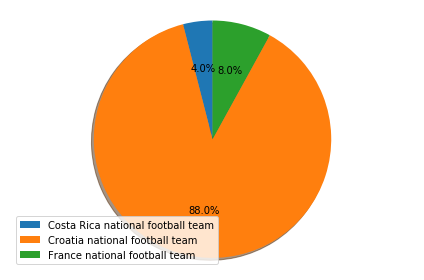

In [45]:
create_PieChart(pearson_correaltion_croatia)

As we already expected, the result is much better. Only three player were not predicted right. Therefore the pearson correlation method works also very good to identify the players in each team. However this method requires that the teams have match days on different dates. Therefore we can identify players from teams who reached the finals/semifinals.. better than teams who were eliminated during the group matches. 

#### Building a graph
In the next step we will built a network out of the data we obtained. For this we will run the pearson correlation for every player in the network and afterwards built a weighted adjacency matrix. This will then be used to create the nodes and edges of the graph to finally built the graph.

In [46]:
pearson_array = np.nan_to_num(pearson_array)
pearson_array = np.absolute(pearson_array)
        
pearson_sparsified = pearson_array[:50, :50]

In [47]:
def modify_pearson_array(pearson_array):
    source = []                   
    target = []                   
    n = len(pearson_array)
    counter = 0
    for i in range(n):
        for j in range(n):
            if pearson_array[i,j] > 0.9 and i is not j:
                source.append(i)
                target.append(j)
                counter += 1
    print("Percentage removed: " + str(1-counter/(n*n)))
    return source, target

Because our graph has in the instial state over 250.000 edges, we will reduce them to a amout of 5.000 using only the most correlated ones. In addition we will add the true label of the teams to each player in order to check if our pearson correlation acually clusters the teams right. 

In [48]:
source, target = modify_pearson_array(pearson_array)

Percentage removed: 0.9807678107277883


In [49]:
d = {'source': source, 'target': target}
edges = pd.DataFrame(data=d)
edges.to_csv('./Data/edges.csv', index = False)

In [50]:
players_csv = pd.read_csv("./Data/All_Players.csv", sep=',', encoding= 'utf-8')

In [51]:
players_csv = players_csv.reset_index()

In [52]:
def create_players_with_teams(true_list, players_csv):
    players_index = []
    for i in range(736):
        players_index.append(i)
    players_with_teams = check_true_label(players_index, true_list, players_csv, 1)
    return players_with_teams

In [53]:
players_with_teams = create_players_with_teams(true_list, players_csv)

Players found: 674/736 nodes


In [54]:
players_with_teams.to_csv('./Data/nodes.csv', index = False)

In [55]:
def modify_pearson_array_23_player(pearson_array):
    source = []                   
    target = []                   
    n = len(pearson_array)
    counter = 0
    maxplayer = 23
    for i in range(n):             #row
        for j in range(n):         #column
            buffer = pearson_array[i,:]
            buffer = np.sort(buffer)
            n = len(buffer)
            upperbound = buffer[n-maxplayer]
            if pearson_array[i,j] > upperbound and i is not j:
                source.append(i)
                target.append(j)
                counter += 1
    print("Percentage removed: " + str(1-counter/(n*n)))
    return source, target

In [56]:
source_23, target_23 = modify_pearson_array_23_player(pearson_array)

Percentage removed: 0.9707788132088847


In [57]:
d = {'source': source_23, 'target': target_23}
edges = pd.DataFrame(data=d)
edges.to_csv('./Data/edges_23_players.csv', index = False)

![Alt text](./Images/TASK4_Pearson_Correlation.png)


On this graph we can see the clustering based on the pearson correlation. In order to compute this graph we used gephi and the layout "force atlas" with a gravity of 22. Afterwards we colored the nodes based on the true label of the team. As a result we can see a nice clustering where many teams are predicted right. However there are a few nodes that are note clustered right. Again this might be because of the fact than most of the teams only took part at the group matches and therefore had no "unique" matches. France and Croatia for example are very well clustered, while Germany and Mexico are not, because they did not have many unique matches.

![Alt text](./Images/TASK4_Pearson_Correlation_23_players.png)

In the next graph we computed used the same graph but now we did not set a certrain threshold but instead looked in every row of the pearson array for the 23 highest values. Those were then set to 1, where all the other entries were set to 0. As a result we get a slightly differerent graph, but the team clustering is a more clear.